In [ ]:
%load_ext tensorboard
%tensorboard --logdir /path/to/logs

In [ ]:
import os
from PIL import Image
import numpy as np
import pickle
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.layers import BatchNormalization
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!unzip "/content/drive/My Drive/PlantVillage.zip" -d "/content/dataset"


Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/PlantVillage/Tomato_Bacterial_spot/f2cfc53d-a165-47d5-a9ac-6877e52a97b6___GCREC_Bact.Sp 3804.JPG  
  inflating: /content/dataset/__MACOSX/PlantVillage/Tomato_Bacterial_spot/._f2cfc53d-a165-47d5-a9ac-6877e52a97b6___GCREC_Bact.Sp 3804.JPG  
  inflating: /content/dataset/PlantVillage/Tomato_Bacterial_spot/4c24021e-90e2-4b84-89c2-c904dc8bb0b4___GCREC_Bact.Sp 5706.JPG  
  inflating: /content/dataset/__MACOSX/PlantVillage/Tomato_Bacterial_spot/._4c24021e-90e2-4b84-89c2-c904dc8bb0b4___GCREC_Bact.Sp 5706.JPG  
  inflating: /content/dataset/PlantVillage/Tomato_Bacterial_spot/9be85690-9fdb-4ddd-b007-686bc4074786___GCREC_Bact.Sp 5780.JPG  
  inflating: /content/dataset/__MACOSX/PlantVillage/Tomato_Bacterial_spot/._9be85690-9fdb-4ddd-b007-686bc4074786___GCREC_Bact.Sp 5780.JPG  
  inflating: /content/dataset/PlantVillage/Tomato_Bacterial_spot/0b233197-cd35-4031-80c2-610e7e3a046b___GCREC_Bact.Sp 6095.JPG  
  inflating: 

In [ ]:
EPOCHS = 30
INIT_LR = 1e-3
BS = 32
default_image_size = tuple((75, 75))
image_size = 0
directory_root = '../content/dataset/PlantVillage'
width=75
height=75
depth=3

In [ ]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [ ]:


directory_root = '/content/dataset/PlantVillage'
image_list, label_list = [], []

for root, dirs, files in os.walk(directory_root):
    for file in files:
        if file.endswith(".jpg") or file.endswith(".JPG"):
            image_path = os.path.join(root, file)
            image_list.append(convert_image_to_array(image_path))
            label_list.append(root.split("/")[-1])


print(f"Loaded images: {len(image_list)}")


Loaded images: 16010


In [ ]:
image_size = len(image_list)
print(image_size)

16010


In [ ]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

In [ ]:
print(label_binarizer.classes_)

['Tomato_Bacterial_spot' 'Tomato_Early_blight' 'Tomato_Late_blight'
 'Tomato_Leaf_Mold' 'Tomato_Septoria_leaf_spot'
 'Tomato_Spider_mites_Two_spotted_spider_mite' 'Tomato__Target_Spot'
 'Tomato__Tomato_YellowLeaf__Curl_Virus' 'Tomato__Tomato_mosaic_virus'
 'Tomato_healthy']


In [ ]:
np_image_list = np.array(image_list, dtype=np.float16) / 225.0

In [ ]:
print("[INFO] Spliting data to train, test")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state=42)



[INFO] Spliting data to train, test


In [ ]:
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2,
    zoom_range=0.2,horizontal_flip=True,
    fill_mode="nearest")

In [ ]:
model = Sequential()
inputShape = (height, width, depth)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)
    chanDim = 1
model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(n_classes))
model.add(Activation("softmax"))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 75, 75, 32)        896       
                                                                 
 activation (Activation)     (None, 75, 75, 32)        0         
                                                                 
 batch_normalization (Batch  (None, 75, 75, 32)        128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 25, 25, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 25, 25, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 25, 64)        1

In [ ]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=INIT_LR,
    decay_steps=1000,
    decay_rate=0.9)

opt = Adam(learning_rate=lr_schedule)

model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
print("[INFO] Training network...")

[INFO] Training network...


In [ ]:
history = model.fit(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS, verbose=1
    )


Epoch 1/30
400/400 [==============================] - 47s 79ms/step - loss: 0.2759 - accuracy: 0.6099 - val_loss: 0.7843 - val_accuracy: 0.1974
Epoch 2/30
400/400 [==============================] - 31s 77ms/step - loss: 0.1131 - accuracy: 0.8006 - val_loss: 0.4021 - val_accuracy: 0.4535
Epoch 3/30
400/400 [==============================] - 32s 79ms/step - loss: 0.0949 - accuracy: 0.8356 - val_loss: 0.2829 - val_accuracy: 0.5931
Epoch 4/30
400/400 [==============================] - 30s 74ms/step - loss: 0.0804 - accuracy: 0.8617 - val_loss: 0.1243 - val_accuracy: 0.7839
Epoch 5/30
400/400 [==============================] - 32s 79ms/step - loss: 0.0692 - accuracy: 0.8822 - val_loss: 0.3036 - val_accuracy: 0.6312
Epoch 6/30
400/400 [==============================] - 31s 78ms/step - loss: 0.0642 - accuracy: 0.8928 - val_loss: 0.1600 - val_accuracy: 0.7870
Epoch 7/30
400/400 [==============================] - 31s 77ms/step - loss: 0.0588 - accuracy: 0.9026 - val_loss: 0.1250 - val_accuracy:

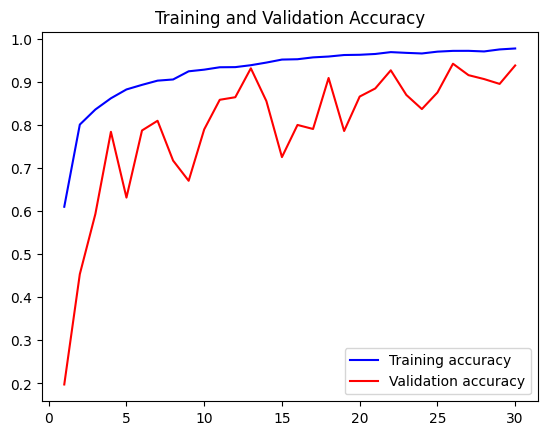

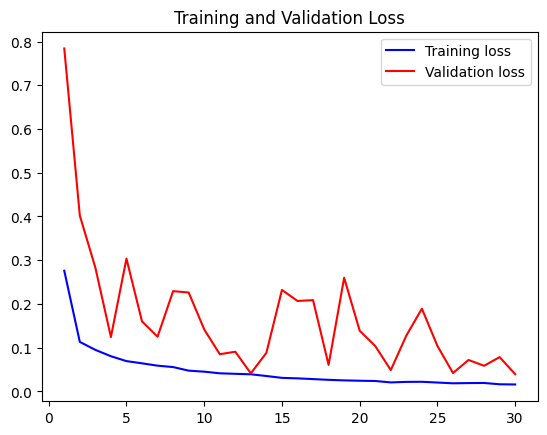

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


In [ ]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
101/101 [==============================] - 1s 10ms/step - loss: 0.0393 - accuracy: 0.9379
Test Accuracy: 93.78513693809509


In [ ]:
y_pred_classes = np.argmax(model.predict(x_test), axis=1)
y_true = np.argmax(y_test, axis=1)

# Generate the classification report
clr = classification_report(y_true, y_pred_classes, target_names=label_binarizer.classes_)
print(clr)

101/101 [==============================] - 1s 4ms/step
                                             precision    recall  f1-score   support

                      Tomato_Bacterial_spot       0.98      0.87      0.92       435
                        Tomato_Early_blight       0.86      0.97      0.91       196
                         Tomato_Late_blight       1.00      0.95      0.98       371
                           Tomato_Leaf_Mold       0.99      0.95      0.97       188
                  Tomato_Septoria_leaf_spot       0.94      0.99      0.97       362
Tomato_Spider_mites_Two_spotted_spider_mite       0.89      0.92      0.90       318
                        Tomato__Target_Spot       0.94      0.76      0.84       295
      Tomato__Tomato_YellowLeaf__Curl_Virus       0.97      0.99      0.98       664
                Tomato__Tomato_mosaic_virus       0.82      1.00      0.90        72
                             Tomato_healthy       0.86      1.00      0.92       301

        

In [ ]:

def plot_confusion_matrix(y_true, y_pred, classes, normalize='true', title=None, cmap=plt.cm.Blues):
    matrix = confusion_matrix(y_true=y_true, y_pred=y_pred, normalize=normalize)
    ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=np.arange(classes)).plot(cmap=cmap)
    plt.title('Normalized confusion matrix ({})'.format(title))
    #plt.savefig('./figures/confusion_matrix_' + title + '.png')
    plt.show()

[[380  18   0   0   2   9  12  14   0   0]
 [  0 190   0   0   2   4   0   0   0   0]
 [  0   9 353   2   3   0   1   2   1   0]
 [  0   0   0 178   9   0   0   0   1   0]
 [  1   0   0   0 359   0   0   1   1   0]
 [  0   0   0   0   0 291   2   0   3  22]
 [  0   4   0   0   7  22 223   0  10  29]
 [  8   0   0   0   0   0   0 656   0   0]
 [  0   0   0   0   0   0   0   0  72   0]
 [  0   0   0   0   0   0   0   0   0 301]]


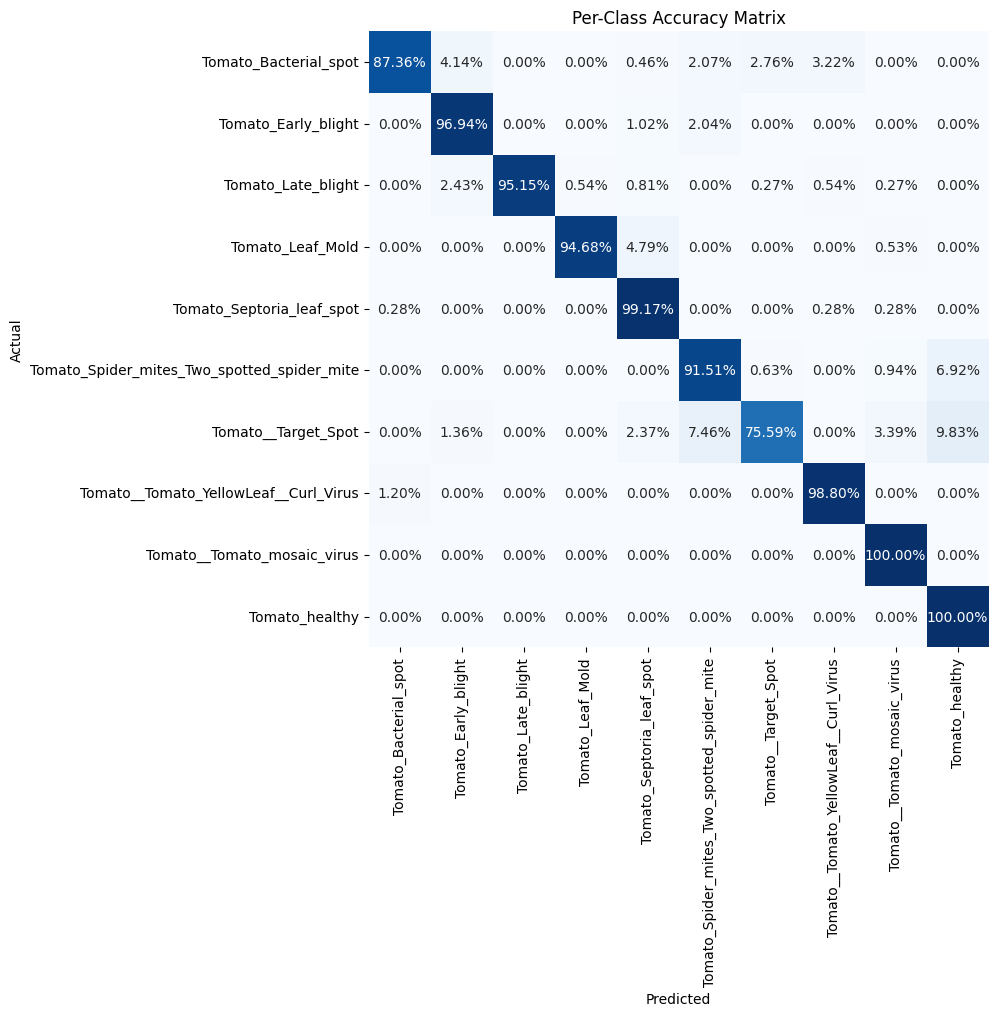

In [ ]:
import tensorflow as tf
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# acc = accuracy_score(y_true, y_pred_classes)


cm = tf.math.confusion_matrix(y_true, y_pred_classes).numpy()
print(cm)
# accuracy_per_class = np.diag(cm) / np.sum(cm, axis=1)
# print(accuracy_per_class)
# accuracy_matrix = np.zeros_like(cm, dtype=float)
# np.fill_diagonal(accuracy_matrix, accuracy_per_class)
cm_sum = np.sum(cm, axis=1, keepdims=True)
cm_ratio = cm / cm_sum.astype(float)

plt.figure(figsize=(8, 8))
sns.heatmap(cm_ratio, annot=True, fmt='.2%', vmin=0, vmax=1, cmap='Blues', cbar=False)
plt.xticks(ticks=np.arange(len(label_binarizer.classes_)) + 0.5, labels=label_binarizer.classes_, rotation=90)
plt.yticks(ticks=np.arange(len(label_binarizer.classes_)) + 0.5, labels=label_binarizer.classes_, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Per-Class Accuracy Matrix")
plt.show()


<Figure size 1000x800 with 0 Axes>

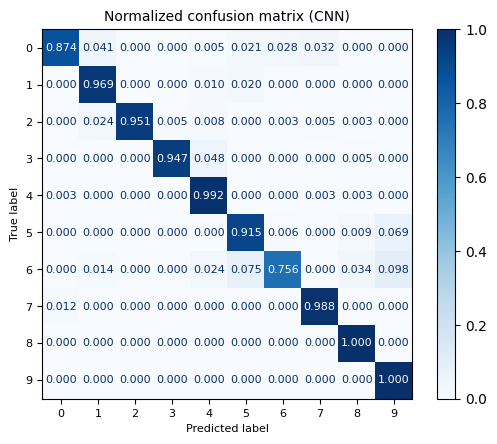

In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes, normalize='true', title=None, cmap=plt.cm.Blues,
                          figsize=(10, 8), font_size=8):
    matrix = confusion_matrix(y_true=y_true, y_pred=y_pred, normalize=normalize)
    plt.figure(figsize=figsize)
    display = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=np.arange(classes))
    display.plot(cmap=cmap, values_format='.3f')

    plt.title('Normalized confusion matrix ({})'.format(title), fontsize=font_size+2)
    plt.xticks(fontsize=font_size)
    plt.yticks(fontsize=font_size)
    plt.xlabel('Predicted label', fontsize=font_size)
    plt.ylabel('True label', fontsize=font_size)

    # Set the font size of the annotations
    for text in display.text_.flatten():
        text.set_fontsize(font_size)

    # Uncomment the line below to save the figure if needed
    # plt.savefig('./figures/confusion_matrix_' + title + '.png')

    plt.show()


plot_confusion_matrix(y_true, y_pred_classes, 10, 'true', 'CNN')